In [108]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
import pandas as pd
import numpy as np
import random

In [110]:
k, b = random.random(), random.random()

In [111]:
k, b

(0.2638748795409982, 0.5680563845048734)

In [112]:
NUM = 1000

In [113]:
X = [float(x) for x in range(NUM)]

In [126]:
Y = [k*x**0.9 + b + 1.2* random.random() for x in X]

In [127]:
import matplotlib.pyplot as plt

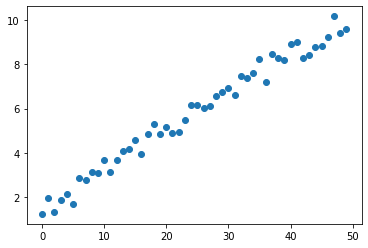

In [128]:
plt.scatter(X[:50],Y[:50])
plt.show()

In [129]:
from torch import nn
import torch

In [130]:
import torch.nn.functional as F

In [171]:
train_x, train_y = torch.tensor(X[:800]).unsqueeze(-1),torch.tensor(Y[:800])

In [172]:
valid_x, valid_y = torch.tensor(X[800:]).unsqueeze(-1),torch.tensor(Y[800:])

In [133]:
class Model0(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(1, 50)
        self.out = nn.Linear(50, 1)
    
    def forward(self, x):
        return self.out(F.relu(self.lin(x)))

In [134]:
model = Model0()

In [135]:
bs=64

xb = train_x[0:bs]
preds = model(xb)
xb[0], preds[0], preds.shape

(tensor([0.]),
 tensor([-0.0574], grad_fn=<SelectBackward>),
 torch.Size([64, 1]))

In [136]:
yb = train_y[:bs]

In [137]:
def rmse(output, targ): return (output.squeeze(-1) - targ).pow(2).mean().sqrt()

In [138]:
rmse(model(train_x[0:bs]), yb[:bs])

tensor(10.2421, grad_fn=<SqrtBackward>)

In [139]:
def fit(model, X, Y, loss_func=rmse,epochs=10, bs=64, lr=0.5, metrics=None):
    for epoch in range(epochs):
        for i in range((len(X)-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = X[start_i:end_i]
            yb = Y[start_i:end_i]
            
            loss = loss_func(model(xb), yb)
                
            loss.backward()
            with torch.no_grad():
                for l in [model.lin, model.out]:
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()
        with torch.no_grad():
            print('epoch: ', epoch, 'train-loss: ', loss_func(model(X), Y))

In [140]:
model = Model0()
fit(model, train_x, train_y, lr=0.001, epochs=10)

epoch:  0 train-loss:  tensor(7.2183)
epoch:  1 train-loss:  tensor(40.9822)
epoch:  2 train-loss:  tensor(88.8809)
epoch:  3 train-loss:  tensor(57.2510)
epoch:  4 train-loss:  tensor(41.9082)
epoch:  5 train-loss:  tensor(83.3986)
epoch:  6 train-loss:  tensor(98.7824)
epoch:  7 train-loss:  tensor(61.9085)
epoch:  8 train-loss:  tensor(41.9464)
epoch:  9 train-loss:  tensor(83.0942)


In [141]:
rmse(model(train_x[0:bs]), yb[:bs])

tensor(4.3007, grad_fn=<SqrtBackward>)

In [142]:
for name,l in model.named_children(): print(f"{name}: {l}")

lin: Linear(in_features=1, out_features=50, bias=True)
out: Linear(in_features=50, out_features=1, bias=True)


In [143]:
from torch import optim

In [144]:
def fit(model, X, Y, loss_func=rmse,epochs=10, bs=64, opt=None, metrics=None):
    for epoch in range(epochs):
        model.train()
        for i in range((len(X)-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = X[start_i:end_i]
            yb = Y[start_i:end_i]
            
            loss = loss_func(model(xb), yb)
                
            loss.backward()
            opt.step()
        model.eval()
        with torch.no_grad():
            print('epoch: ', epoch, 'train-loss: ', loss_func(model(X), Y))

In [145]:
model = Model0()
fit(model, train_x, train_y, epochs=11, opt=optim.SGD(model.parameters(), lr=0.001))

epoch:  0 train-loss:  tensor(8.1604)
epoch:  1 train-loss:  tensor(65.4198)
epoch:  2 train-loss:  tensor(65.2275)
epoch:  3 train-loss:  tensor(64.8878)
epoch:  4 train-loss:  tensor(64.4015)
epoch:  5 train-loss:  tensor(63.7698)
epoch:  6 train-loss:  tensor(62.9943)
epoch:  7 train-loss:  tensor(62.0775)
epoch:  8 train-loss:  tensor(61.0227)
epoch:  9 train-loss:  tensor(59.8347)
epoch:  10 train-loss:  tensor(58.5202)


In [146]:
rmse(model(train_x[0:bs]), yb[:bs])

tensor(3.9106, grad_fn=<SqrtBackward>)

In [147]:
model(train_x[0])

tensor([-16.3248], grad_fn=<AddBackward0>)

## Normalize

In [148]:
def normalize(x, m, s): return (x-m)/s

In [149]:
train_mean,train_std = train_x.mean(),train_x.std()
train_mean,train_std

(tensor(399.5000), tensor(231.0844))

In [150]:
train_x = normalize(train_x, train_mean, train_std)
valid_x = normalize(valid_x, train_mean, train_std)

In [151]:
train_x.mean(),train_x.std()

(tensor(-1.3411e-09), tensor(1.))

In [152]:
model = Model0()
fit(model, train_x, train_y, epochs=10, opt=optim.SGD(model.parameters(), lr=0.001))

epoch:  0 train-loss:  tensor(64.9159)
epoch:  1 train-loss:  tensor(62.9049)
epoch:  2 train-loss:  tensor(59.1113)
epoch:  3 train-loss:  tensor(52.3038)
epoch:  4 train-loss:  tensor(39.3346)
epoch:  5 train-loss:  tensor(15.5663)
epoch:  6 train-loss:  tensor(29.3599)
epoch:  7 train-loss:  tensor(45.8462)
epoch:  8 train-loss:  tensor(36.2980)
epoch:  9 train-loss:  tensor(22.4976)


## Adam

In [153]:
model = Model0()
fit(model, train_x, train_y, epochs=10, opt=optim.Adam(model.parameters(), lr=0.01))

epoch:  0 train-loss:  tensor(64.0016)
epoch:  1 train-loss:  tensor(61.1815)
epoch:  2 train-loss:  tensor(56.3968)
epoch:  3 train-loss:  tensor(48.9029)
epoch:  4 train-loss:  tensor(38.2185)
epoch:  5 train-loss:  tensor(24.5819)
epoch:  6 train-loss:  tensor(14.3441)
epoch:  7 train-loss:  tensor(28.6076)
epoch:  8 train-loss:  tensor(46.3908)
epoch:  9 train-loss:  tensor(53.7689)


## Regularization

In [154]:
model = Model0()
fit(model, train_x, train_y, epochs=10, opt=optim.Adam(model.parameters(), lr=0.01, weight_decay=0.5))

epoch:  0 train-loss:  tensor(64.2175)
epoch:  1 train-loss:  tensor(63.1123)
epoch:  2 train-loss:  tensor(62.0904)
epoch:  3 train-loss:  tensor(59.9653)
epoch:  4 train-loss:  tensor(55.1754)
epoch:  5 train-loss:  tensor(46.4423)
epoch:  6 train-loss:  tensor(32.8039)
epoch:  7 train-loss:  tensor(13.7052)
epoch:  8 train-loss:  tensor(11.8694)
epoch:  9 train-loss:  tensor(17.8603)


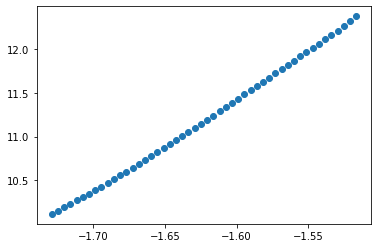

In [155]:
with torch.no_grad():
    plt.scatter(train_x[0:50], model(train_x[0:50]))
    plt.show()

## Batch-size - speed

In [156]:
model = Model0()

In [157]:
%time fit(model, train_x, train_y, epochs=10, opt=optim.Adam(model.parameters(), lr=0.01), bs=1)

epoch:  0 train-loss:  tensor(250.4266)
epoch:  1 train-loss:  tensor(142.5893)
epoch:  2 train-loss:  tensor(184.5352)
epoch:  3 train-loss:  tensor(459.9965)
epoch:  4 train-loss:  tensor(1299.4797)
epoch:  5 train-loss:  tensor(1913.6932)
epoch:  6 train-loss:  tensor(772.7200)
epoch:  7 train-loss:  tensor(58.9437)
epoch:  8 train-loss:  tensor(184.7767)
epoch:  9 train-loss:  tensor(192.7602)
CPU times: user 3.58 s, sys: 148 ms, total: 3.73 s
Wall time: 3.74 s


In [158]:
%time fit(model, train_x, train_y, epochs=10, opt=optim.Adam(model.parameters(), lr=0.01), bs=64)

epoch:  0 train-loss:  tensor(195.8223)
epoch:  1 train-loss:  tensor(199.1195)
epoch:  2 train-loss:  tensor(202.5875)
epoch:  3 train-loss:  tensor(206.1645)
epoch:  4 train-loss:  tensor(209.7884)
epoch:  5 train-loss:  tensor(213.4239)
epoch:  6 train-loss:  tensor(217.0175)
epoch:  7 train-loss:  tensor(220.5327)
epoch:  8 train-loss:  tensor(223.9276)
epoch:  9 train-loss:  tensor(227.1666)
CPU times: user 88 ms, sys: 8 ms, total: 96 ms
Wall time: 90.7 ms


In [40]:
%time fit(model, train_x, train_y, epochs=10, opt=optim.Adam(model.parameters(), lr=0.01), bs=1000)

epoch:  0 train-loss:  tensor(70.0161)
epoch:  1 train-loss:  tensor(70.0260)
epoch:  2 train-loss:  tensor(70.0357)
epoch:  3 train-loss:  tensor(70.0454)
epoch:  4 train-loss:  tensor(70.0560)
epoch:  5 train-loss:  tensor(70.0674)
epoch:  6 train-loss:  tensor(70.0787)
epoch:  7 train-loss:  tensor(70.0900)
epoch:  8 train-loss:  tensor(70.1016)
epoch:  9 train-loss:  tensor(70.1142)
CPU times: user 56 ms, sys: 8 ms, total: 64 ms
Wall time: 34.5 ms


## Batchnorm

In [159]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(1, 50)
        self.out = nn.Linear(50, 1)
        self.bn = nn.BatchNorm1d(50)
    
    def forward(self, x):
        return self.out(self.bn(F.relu(self.lin(x))))

In [160]:
model = Model1()
rmse(model(train_x[0:bs]), yb[:bs])

tensor(7.7710, grad_fn=<SqrtBackward>)

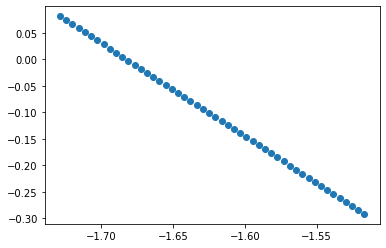

In [161]:
with torch.no_grad():
    plt.scatter(train_x[0:50], model(train_x[0:50]))
    plt.show()

In [162]:
fit(model, train_x, train_y, epochs=10, opt=optim.Adam(model.parameters(), lr=0.01))
rmse(model(train_x[0:bs]), yb[:bs])

epoch:  0 train-loss:  tensor(64.8108)
epoch:  1 train-loss:  tensor(62.8491)
epoch:  2 train-loss:  tensor(62.0029)
epoch:  3 train-loss:  tensor(53.0166)
epoch:  4 train-loss:  tensor(51.6570)
epoch:  5 train-loss:  tensor(43.4305)
epoch:  6 train-loss:  tensor(68.2420)
epoch:  7 train-loss:  tensor(142.9000)
epoch:  8 train-loss:  tensor(113.7569)
epoch:  9 train-loss:  tensor(64.7408)


tensor(113.5960, grad_fn=<SqrtBackward>)

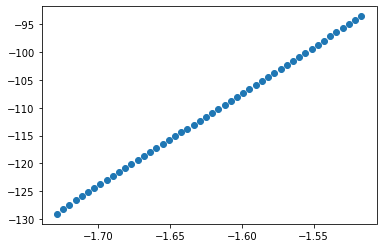

In [163]:
with torch.no_grad():
    plt.scatter(train_x[0:50], model(train_x[0:50]))
    plt.show()

## With fastai

In [164]:
from fastai import *
from fastai.text import *

In [165]:
bs=64

In [166]:
class DatasetL(Dataset):
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [173]:
data = (DataBunch(DataLoader(DatasetL(train_x, train_y), bs, shuffle=True), 
                DataLoader(DatasetL(valid_x, valid_y), bs, shuffle=False)))

In [174]:
learner = Learner(data, Model1(), loss_func=rmse)

In [175]:
learner.fit(30, lr=0.01)

epoch,train_loss,valid_loss,time
0,64.522514,108.962914,00:00
1,62.683258,98.467133,00:00
2,59.667717,82.730057,00:00
3,55.283489,64.045158,00:00
4,49.048973,41.003139,00:00
5,41.105141,26.196064,00:00
6,32.081734,3.969529,00:00
7,24.671066,7.384361,00:00
8,19.326067,12.460004,00:00
9,15.304518,0.522137,00:00


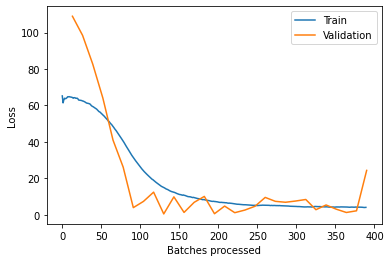

In [176]:
learner.recorder.plot_losses()